#Исследование датасета подписок видеосервиса

###Вводные данные и задачи

Датасет с данными об оформленных подписках.

Задачи:


1. Рассчитать 3 таблицы с агрегацией по дням, месяцам для диапазона дат
‘2020-01-01’ - ‘2020-06-30’ со следующими расчетными полями:

   - выручка (тотал, разбивка по платформам)

   - количество начавшихся подписок (тотал, разбивка по платформам, разбивка по
типам подписки)

  - средняя стоимость оформленной подписки (тотал, разбивка по платформам)

  - количество окончившихся подписок (тотал, разбивка по платформам, разбивка
  по типам подписки)

  - количество новых пользователей (оформили свою первую подписку. Тотал,
  разбивка по платформам)

  - количество ушедших пользователей (дата окончания текущей подписки меньше
  даты старта следующей или же следующая подписка отсутствует. Тотал,
  разбивка по платформам)

  - количество вернувшихся пользователей (дата старта текущей подписки больше
  даты окончания предыдущей. Тотал, разбивка по платформам)

2. Сгенерировать дополнительные метрики на основе метрик из пункта 1, описать их.

3. Сделать сравнение значений наиболее важных метрик между платформами.
Для этих метрик описать динамику по месяцам и возможные причины ее
возникновения.

In [ ]:
# загрузим все необходимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [ ]:
# загрузим файл

from google.colab import files

data = files.upload()

Saving subscriptions.csv to subscriptions.csv


## Предобработка данных

In [ ]:
# загрузим датасет в переменную df и выведем информацию о нем

df = pd.read_csv('subscriptions.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80505 entries, 0 to 80504
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uid               80505 non-null  object
 1   start_ts          80504 non-null  object
 2   end_ts            80505 non-null  object
 3   payment_platform  80505 non-null  object
 4   kind              80505 non-null  object
 5   money             80505 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 3.7+ MB


In [ ]:
# выведем на экран первые 5 строк датасета

df.head()

,uid,start_ts,end_ts,payment_platform,kind,money
0,HnPPDWq1WoFh9KyEEpvtv5,2020-05-01 00:18:23.000,2020-05-31 00:18:23.000,GOOGLE,sub,29
1,71SLChvDuJV1i4uDWusLQa,2019-12-21 09:51:45.000,2020-01-21 09:51:45.000,GOOGLE,sub,129
2,9wLqpYoEwEUbJyryroTB3p,2019-12-28 20:12:22.000,2020-01-28 20:12:22.000,GOOGLE,sub,129
3,XSJCBc5KADrk6tZFoZULrP,2020-05-09 12:21:47.000,2020-06-09 12:21:47.000,GOOGLE,sub,29
4,2mUYQ79xKe4hbEFmXp1bPa,2020-06-02 19:35:51.000,2020-07-02 19:35:51.000,GOOGLE,sub,29


В датасете представлено 80505 строк. В столбце start_ts есть 1 пропуск. 

In [ ]:
# выведем пропуск на экран

df[df['start_ts'].isna()]

,uid,start_ts,end_ts,payment_platform,kind,money
439,vjhububbhhbs72,NaN,2020-05-03 20:38:39.000,YANDEX,sub,1000


В строке не указана дата начала подписки, при этом строчка ее окончания присутствует. Стоимость подписки в строке явно указана некорректно.

In [ ]:
# удалим из датасета строчку с пропуском

df.dropna(subset=['start_ts'], inplace=True)

In [ ]:
# приведем данные столбцов start_ts и end_ts к типу datetime

df['start_ts'] = pd.to_datetime(df['start_ts'])
df['end_ts'] = pd.to_datetime(df['end_ts'])



In [ ]:
# посмотрим, за какой период в датесете представлены данные

print('Минимальная дата старта подписки:', df['start_ts'].min())
print('Максимальная дата старта подписки',  df['start_ts'].max())

print('Минимальная дата окончания подписки:', df['end_ts'].min())
print('Максимальная дата окончания подписки',  df['end_ts'].max())

Минимальная дата старта подписки: 2018-12-21 22:56:04
Максимальная дата старта подписки 2020-07-01 02:59:47
Минимальная дата окончания подписки: 2020-01-01 03:22:27
Максимальная дата окончания подписки 2021-02-24 19:39:29


В датасете представлены данные за период с 21 декабря 2018 года по 24 февраля 2021 года.

In [ ]:
# проверим датасет на явные дубликаты

df.duplicated().sum()

0

Явных дубликатов в датасете нет.

In [ ]:
# изучим уникальные значения столбца payment_platform

df['payment_platform'].unique()

array(['GOOGLE', 'YANDEX', 'APPLE'], dtype=object)

Неявных дубликатов в столбце нет.

In [ ]:
# изучим уникальные значения столбца kind

df['kind'].unique()

array(['sub', 'trial', 'sub_discount'], dtype=object)

В столбце представлено три типа подписки. Их наименования указаны корректно.

In [ ]:
# изучим уникальные значения столбца money

df['money'].unique()

array([    29,    129,      0,  80000, -10000])

In [ ]:
df['money'].value_counts()

 29       56585
 129      22312
 0         1605
 80000        1
-10000        1
Name: money, dtype: int64

Значения со стоимостью подписки в 80 тыс. и -10 тыс. в столбце явно указаны некорректно. Удалим их из датасета:

In [ ]:
df.query('(money <= 129) & (money >= 0)').reset_index(drop=True,inplace=True)

Проверим периоды подписок на последовательность, чтобы избежать пересекающихся диапазонов. Создадим столбец, в который добавим значением True, если период текущей подписки пересекается с предыдущей.

In [ ]:
# отсортируем датафрейм по убыванию uid и периодов подписки

df_sorted = df.sort_values(['uid', 'start_ts'], ascending=[True,True])


# проверим периоды подписок на пересечения
df_sorted['overlap'] = (df_sorted.groupby('uid')
                   .apply(lambda x: (x['start_ts'].shift() - x['end_ts']) > timedelta(0))
                   .reset_index(level=0, drop=True))

# посчитаем пересесечения в датасете

df_sorted['overlap'].value_counts()

False    80504
Name: overlap, dtype: int64

Пересечений по периодам нет.

In [ ]:
# создадим столбец с длительностью сессий подписок и отсортируем по убыванию

df['duration'] = (df['end_ts'] - df['start_ts']).dt.days


# посмотрим топ-15 подписок по продолжительности
df.sort_values('duration', ascending=False).head(15)


,uid,start_ts,end_ts,payment_platform,kind,money,duration
13295,nzyf6Qsg8qaZqjCJXGcjk,2018-12-21 22:56:04,2020-03-21 18:07:42,APPLE,trial,0,455
77024,TczqTSeEgQFX1dxF3FKTbh,2020-01-25 19:39:29,2021-02-24 19:39:29,YANDEX,sub,129,396
34338,9VmUBoj2MuGBs6ydZ8Ca1D,2020-01-06 18:18:57,2021-02-05 18:18:57,YANDEX,sub,129,396
49300,JaJ4YpGrdhD9SwFw6phEPY,2020-01-04 20:19:29,2021-01-29 22:24:21,YANDEX,sub,29,391
58014,QzdSk6Ri4w58YH8E5o16xm,2020-01-20 01:18:40,2021-01-22 01:18:40,YANDEX,trial,0,368
28178,FTPTiebG77UpbtmaXeKvko,2020-02-06 13:49:05,2021-02-05 13:49:05,YANDEX,trial,0,365
5102,8k61LJbbsr5oXWQm4nDiUp,2020-02-05 16:43:24,2021-01-30 16:43:24,YANDEX,trial,0,360
64592,GoVAiJ5J287crpkkumc4KL,2019-11-18 17:43:04,2020-01-20 17:43:04,YANDEX,trial,0,63
4191,UGBx36EzGwepUgBazSgMWM,2020-02-15 17:46:01,2020-04-15 17:46:01,YANDEX,sub_discount,0,60
71260,AWYYwZq3w4dqYXaGekBfDh,2020-02-15 11:26:52,2020-04-15 11:26:52,YANDEX,sub_discount,0,60


In [ ]:
# посчитаем число срок с разной продолжительностью подписки

df['duration'].value_counts()

 31     43223
 30     24135
 29      8368
 28      3377
 3       1323
 60        32
 45        29
 396        2
 1          2
 43         2
 63         1
 368        1
 391        1
 22         1
 360        1
 365        1
 7          1
 455        1
-1          1
-31         1
 18         1
Name: duration, dtype: int64

- Большая часть подписок имеет месячную продолжительность.

- В датасете есть подписки длиной в больше года. При этом часть из них - триалы.

- В датасете есть подписки с отрицательным показателем продолжительности. Это значит, что время окончания подписки у них меньше, чем время начала. Удалим такие строки из датасета:





In [ ]:
df = df[df['duration'] > 0].reset_index()

_____
В ходе предобработки данных мы:

- Проверили датасет на пропуски. Обнаружили строчку с одним пропуском, которую удалили.
- Проверили датасет на дубликаты. Подобных строк мы не выявили.
- Проверили столбцы с категориальными значениями. Обнаружили 3 значения со стоимостью подписки в 80 тыс. и -10 тыс. Их из датасета мы удалили.
- Привели данные столбцов с временем к типу datetime.
- Выяснили, что в датасете представлены данные за период с 21 декабря 2018 года по 24 февраля 2021 года.
- Проверили датасет на пересечения периодов подписок. Их мы не обнаружили. 
- Изучили подписки на продолжительность. Обнаружили подписки с отрицательной длиной сессий. Такие строки мы удалили. 




##Подготовка данных

Создадим столбцы для месяца и дня оформления и окончания подписки:

In [ ]:
df['date'] = pd.to_datetime(df['start_ts'].dt.date)
df['month'] = df['start_ts'].astype('datetime64[M]')

df['end_date'] = pd.to_datetime(df['end_ts'].dt.date)
df['end_month'] = df['end_ts'].astype('datetime64[M]')


Напишем функцию, которая рассчитывает все необходимые по заданию метрики, принимая на вход датасет, вид временных данных, по которым нужно агрегировать итоговые таблицы, и период:

In [ ]:
def group(df, date_type, date_type_end, start_period, end_period): 

  # перезапишем датасет, включив в него только нужный диапазон дат
  df = df[(df['start_ts'] >= start_period) & (df['start_ts'] <= end_period)].reset_index(drop=True)
  df = df[(df['end_ts'] >= start_period) & (df['end_ts'] <= end_period)].reset_index(drop=True)

  # сгруппируем данные по выручке с разбивкой по платформам
  df_date_revenue = df.pivot_table(index=date_type, columns='payment_platform', values='money', aggfunc='sum').reset_index()
  df_date_revenue_total = df.groupby(date_type).agg({'money':'sum'})['money'].reset_index()
  
  df_date_revenue_total = df_date_revenue_total.rename(columns={'money':'total'})
  df_date_revenue = df_date_revenue.merge(df_date_revenue_total, on=date_type)
  df_date_revenue = df_date_revenue.rename(columns={'APPLE':'APPLE_revenue', 'GOOGLE':'GOOGLE_revenue', 'YANDEX':'YANDEX_revenue', 'total':'total_revenue'})

  # вычислим среднюю стоимость оформленной подписки (тотал, разбивка по платформам)
  df_date_avg_revenue = df.pivot_table(index=date_type, columns='payment_platform',  values='money', aggfunc='mean').reset_index()
  df_date_avg_revenue_total = df.groupby(date_type).agg({'money':'mean'})['money'].reset_index()
  df_date_avg_revenue_total = df_date_avg_revenue_total.rename(columns={'money':'total'})
  df_date_avg_revenue = df_date_avg_revenue.merge(df_date_avg_revenue_total, on=date_type)
  df_date_avg_revenue = df_date_avg_revenue.rename(columns={'APPLE':'APPLE_avg_revenue', 'GOOGLE':'GOOGLE_avg_revenue', 'YANDEX':'YANDEX_avg_revenue', 'total':'total_avg_revenue'})

  # округлим значения
  df_date_avg_revenue[['APPLE_avg_revenue', 'GOOGLE_avg_revenue', 'YANDEX_avg_revenue', 'total_avg_revenue']] = round(df_date_avg_revenue[['APPLE_avg_revenue', 'GOOGLE_avg_revenue', 'YANDEX_avg_revenue', 'total_avg_revenue']])


  # сгруппируем количество начавшихся подписок по платформам
  df_date_start_platform = df.pivot_table(index=date_type, columns=['payment_platform'],  values='uid', aggfunc='count').reset_index()
  df_date_start_platform = df_date_start_platform.rename(columns={'APPLE':'APPLE_start_users', 'GOOGLE':'GOOGLE_start_users', 'YANDEX':'YANDEX_start_users', 'total':'total_start_users'})

  # сгруппируем количество начавшихся подписок по типам подписки
  df_date_start_kind = df.pivot_table(index=date_type, columns=['kind'],  values='uid', aggfunc='count').reset_index()
  df_date_start_kind = df_date_start_kind.rename(columns={'sub':'sub_start_users', 'sub_discount':'sub_discount_start_users', 'trial':'trial_start_users'}) 

  # найдем total по числу начавшихся подписок
  df_date_platform_start_total = df.groupby(date_type).agg({'uid':'count'})['uid'].reset_index()
  df_date_platform_start_total = df_date_platform_start_total.rename(columns={'uid':'total_start_users'})

  # объединиv датасеты
  df_date_start_platform = df_date_start_platform.merge(df_date_start_kind, on=date_type, how='outer')
  df_date_start_platform  = df_date_start_platform.merge(df_date_platform_start_total, on=date_type, how='outer') 


  # сгруппируем количество окончившихся подписок и выведем тотал и разбивку по платформам
  df_date_end_platform = df.pivot_table(index=date_type_end, columns=['payment_platform'],  values='uid', aggfunc='count').reset_index()
  df_date_end_platform = df_date_end_platform.rename(columns={date_type_end: date_type,'APPLE':'APPLE_end_users', 'GOOGLE':'GOOGLE_end_users', 'YANDEX':'YANDEX_end_users', 'total':'total_end_users'})

  # сгруппируем количество окончившихся подписок по типам подписки
  df_date_end_kind = df.pivot_table(index=date_type_end, columns='kind',  values='uid', aggfunc='count').reset_index()
  df_date_end_kind = df_date_end_kind.rename(columns={date_type_end: date_type,'sub':'sub_end_users', 'sub_discount':'sub_discount_end_users', 'trial':'trial_end_users'})

  # найдем total по числу окончившихся подписок
  df_date_platform_end_total = df.groupby(date_type_end).agg({'uid':'count'})['uid'].reset_index()
  df_date_platform_end_total = df_date_platform_end_total.rename(columns={date_type_end:date_type,'uid':'total_end_users'})

  #объедимни датасеты 
  df_date_end_platform = df_date_end_platform.merge(df_date_end_kind, on=date_type, how='outer')
  df_date_end_platform = df_date_end_platform.merge(df_date_platform_end_total, on=date_type, how='outer') 


  # сгруппируем датасет по первой и последней дате визите для каждого пользователя
  df_first = df.groupby('uid').agg({'date':'min', 'end_date':'max', 'payment_platform':'first', 'kind':'first'}).reset_index()
  df_first['month'] = df_first['date'].astype('datetime64[M]')


  # сгруппируем данные по датам оформления подписки новыми пользователями и платформам 
  df_date_platform = df_first.pivot_table(index=date_type, columns='payment_platform',  values='uid', aggfunc='nunique').reset_index()
  df_date_platform_total = df_first.groupby(date_type).agg({'uid':'nunique'})['uid'].reset_index()
  df_date_platform_total = df_date_platform_total.rename(columns={'uid':'total'})
  df_date_platform = df_date_platform.merge(df_date_platform_total, on=date_type)
  df_date_platform = df_date_platform.rename(columns={'APPLE':'APPLE_new_users', 'GOOGLE':'GOOGLE_new_users', 'YANDEX':'YANDEX_new_users', 'total':'total_new_users'})


  #	сгруппируем датасет по пользователям и убыванию их даты оформления подписки
  df_returned = df.sort_values(by=['uid','start_ts']).reset_index(drop=True)

  # будем считать вернувшимися пользователями тех, кто сделал перерыв в подписке - более 1 дня, но затем снова оформил подписку
  df_returned['date_shifted'] = df_returned.groupby('uid')['end_date'].shift(1)
  df_returned['returned'] = df_returned['date_shifted'] < df_returned['date']

  # оставим в датасете только тех, у кого разница между датой окончания подписки и старта новой - более одного дня
  df_returned = df_returned[df_returned['returned'] == True]

  # сгруппируем датасет с вернувшимися по платформам
  df_returned_grouped = df_returned.pivot_table(index=date_type, columns = 'payment_platform', values = 'uid', aggfunc='count').reset_index().fillna(0)

  # найдем total 
  df_returned_grouped_total = df_returned.groupby(date_type).agg({'uid':'count'})['uid'].reset_index()
  df_returned_grouped_total = df_returned_grouped_total.rename(columns={'uid':'total_returned_users'})

  # объединим датасеты
  df_returned_grouped = df_returned_grouped.merge(df_returned_grouped_total , on=date_type, how='outer') 
  df_returned_grouped = df_returned_grouped.rename(columns={'APPLE':'APPLE_returned_users', 'GOOGLE':'GOOGLE_returned_users', 'YANDEX':'YANDEX_returned_users', 'total':'total_returned_users'})


  #	сгруппируем датасет по пользователям и убыванию их даты оформления подписки
  df_gone = df.sort_values(by=['uid','start_ts']).reset_index(drop=True)

  # будем считать ушедними пользователями тех, у кого следующая подписка отсутствует
  df_gone['date_shifted'] = df_gone.groupby('uid')['date'].shift(-1)
  df_gone['gone'] = df_gone['date_shifted'].isna()

  # оставим в датасете только ушедших пользователей
  df_gone = df_gone[df_gone['gone'] == True].reset_index(drop=True)

  # сгруппируем датасет с ушедшими пользователями по платформам
  df_gone_grouped = df_gone.pivot_table(index=date_type, columns = 'payment_platform', values = 'uid', aggfunc='count').reset_index().fillna(0)

  # найдем total 
  df_gone_total = df_gone.groupby(date_type).agg({'uid':'count'})['uid'].reset_index()
  df_gone_total = df_gone_total.rename(columns={'uid':'total_gone_users'})

  # объединим датасеты

  df_gone_grouped = df_gone_grouped.merge(df_gone_total , on=date_type, how='outer') 
  df_gone_grouped = df_gone_grouped.rename(columns={'APPLE':'APPLE_gone_users', 'GOOGLE':'GOOGLE_gone_users', 'YANDEX':'YANDEX_gone_users', 'total':'total_gone_users'})



  # объединим датасеты

  df_grouped = df_date_platform.merge(df_date_start_platform, on=date_type, how='outer')
  df_grouped = df_grouped.merge(df_date_end_platform, on=date_type, how='outer')
  df_grouped = df_grouped.merge(df_date_revenue, on=date_type, how='outer')
  df_grouped = df_grouped.merge(df_date_avg_revenue, on=date_type, how='outer')
  df_grouped = df_grouped.merge(df_gone_grouped, on=date_type, how='outer')
  df_grouped = df_grouped.merge(df_returned_grouped, on=date_type, how='outer')


  # заменим пропуски на 0
  df_grouped = df_grouped.fillna(0)

  # изменим тип данных столбцов с числовыми значениями на int
  cols = ['APPLE_new_users', 'GOOGLE_new_users', 'YANDEX_new_users',
       'total_new_users', 'APPLE_start_users', 'GOOGLE_start_users',
       'YANDEX_start_users', 'sub_start_users', 'sub_discount_start_users',
       'trial_start_users', 'total_start_users', 'APPLE_end_users',
       'GOOGLE_end_users', 'YANDEX_end_users', 'sub_end_users',
       'sub_discount_end_users', 'trial_end_users', 'total_end_users',
       'APPLE_revenue', 'GOOGLE_revenue', 'YANDEX_revenue',
       'total_revenue', 'APPLE_avg_revenue', 'GOOGLE_avg_revenue',
       'YANDEX_avg_revenue', 'total_avg_revenue', 'APPLE_gone_users',
       'GOOGLE_gone_users', 'YANDEX_gone_users', 'total_gone_users',
       'APPLE_returned_users', 'GOOGLE_returned_users',
       'YANDEX_returned_users', 'total_returned_users']

  df_grouped[cols] = df_grouped[cols].applymap(np.int64)

  return df_grouped





##Расчет метрик для таблиц

###Данные по месяцам за весь период

In [ ]:
# выведем таблицу с нужными метриками, сгруппированную по месяцам периода с 2020-01-01' по '2020-06-30'

df_grouped_by_month = group(df, 'month', 'end_month', start_period=df['start_ts'].min(), end_period=df['end_ts'].max())
df_grouped_by_month

,month,APPLE_new_users,GOOGLE_new_users,YANDEX_new_users,total_new_users,APPLE_start_users,GOOGLE_start_users,YANDEX_start_users,sub_start_users,sub_discount_start_users,...,YANDEX_avg_revenue,total_avg_revenue,APPLE_gone_users,GOOGLE_gone_users,YANDEX_gone_users,total_gone_users,APPLE_returned_users,GOOGLE_returned_users,YANDEX_returned_users,total_returned_users
0,2018-12-01,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-11-01,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-12-01,4699,2602,4653,11954,4649,2635,4749,11880,21,...,112,121,591,455,722,1768,0,0,0,0
3,2020-01-01,799,591,768,2158,4736,2722,4642,10963,0,...,113,113,532,518,554,1604,332,101,169,602
4,2020-02-01,604,411,588,1603,4516,2628,4516,11517,86,...,33,34,378,436,454,1268,495,236,273,1004
5,2020-03-01,492,384,610,1486,4864,2435,4627,11788,138,...,28,29,469,508,517,1494,400,203,213,816
6,2020-04-01,195,167,376,738,4309,2009,4318,10606,30,...,29,29,346,238,436,1020,203,151,168,522
7,2020-05-01,113,88,274,475,4173,1802,4150,10124,1,...,29,29,365,214,417,996,232,129,161,522
8,2020-06-01,436,369,917,1722,4718,2233,5027,11977,1,...,29,29,4709,2216,5024,11949,647,345,499,1491
9,2020-07-01,0,3,0,3,22,13,7,42,0,...,29,29,22,13,7,42,2,3,0,5


###Данные по датам за весь период

In [ ]:
# выведем таблицу с нужными метриками

df_grouped_by_date = group(df, 'date', 'end_date', start_period=df['start_ts'].min(), end_period=df['end_ts'].max())
df_grouped_by_date


,date,APPLE_new_users,GOOGLE_new_users,YANDEX_new_users,total_new_users,APPLE_start_users,GOOGLE_start_users,YANDEX_start_users,sub_start_users,sub_discount_start_users,...,YANDEX_avg_revenue,total_avg_revenue,APPLE_gone_users,GOOGLE_gone_users,YANDEX_gone_users,total_gone_users,APPLE_returned_users,GOOGLE_returned_users,YANDEX_returned_users,total_returned_users
0,2018-12-21,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-11-18,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-12-01,107,39,121,267,104,38,125,251,16,...,112,121,7,4,10,21,0,0,0,0
3,2019-12-02,97,61,104,262,94,61,107,257,5,...,123,127,10,3,17,30,0,0,0,0
4,2019-12-03,108,65,129,302,107,63,132,302,0,...,129,129,10,8,13,31,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,2021-01-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,2021-01-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,2021-02-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Данные за период с 2020-01-01 по 2020-06-30

In [ ]:
# выведем таблицу с нужными метриками, сгруппированную по датам периода с '2020-01-01' по '2020-06-30'

df_grouped_by_period= group(df, 'month', 'end_month', start_period='2020-01-01', end_period='2020-06-30')
df_grouped_by_period


,month,APPLE_new_users,GOOGLE_new_users,YANDEX_new_users,total_new_users,APPLE_start_users,GOOGLE_start_users,YANDEX_start_users,sub_start_users,sub_discount_start_users,...,YANDEX_avg_revenue,total_avg_revenue,APPLE_gone_users,GOOGLE_gone_users,YANDEX_gone_users,total_gone_users,APPLE_returned_users,GOOGLE_returned_users,YANDEX_returned_users,total_returned_users
0,2020-01-01,4484,2520,4413,11417,4736,2722,4638,10960,0,...,113,113,570,537,579,1686,26,19,8,53
1,2020-02-01,834,524,737,2095,4516,2628,4514,11517,86,...,33,34,442,501,512,1455,266,123,121,510
2,2020-03-01,594,429,664,1687,4864,2435,4627,11788,138,...,28,29,698,641,735,2074,302,156,157,615
3,2020-04-01,220,178,414,812,4309,2009,4318,10606,30,...,29,29,555,338,581,1474,177,140,131,448
4,2020-05-01,120,92,277,489,4020,1743,4081,9843,1,...,29,29,4019,1710,4081,9810,202,113,134,449
5,2020-06-01,0,0,1,1,1,0,1,1,1,...,0,14,1,0,1,2,0,0,0,0


Вывод:

- Мы написали функцию, которая  рассчитывает все необходимые по заданию метрики, принимая на вход датасет, вид временных данных, по которым можно агрегировать итоговые таблицы, и период

- С помощью функции мы составили 3 таблицы: с агрегацией по месяцам, по датам и для диапазона дат ‘2020-01-01’ - ‘2020-06-30’.

##Расчет дополнительных метрик

Рассчитаем дополнительные метрики: лайфтайм подписчиков, MAU,DAU, LTV и Retention.

###Лайфтайм подписчиков

In [ ]:
# создадим датасет с первой датой оформления и датой окончания последней подписки по каждому пользователю и найдем разницу в днях

df_lifetime = df.sort_values(by=['uid', 'date']).groupby('uid', as_index=False).agg({'month':'min', 'end_month':'max'})
df_lifetime['lifetime'] = (df_lifetime['end_month'] - df_lifetime['month']).dt.days

# добавим столбец с разницей в месяцах

df_lifetime['lifetime_month'] = (round(df_lifetime['lifetime'] / 30)).astype('int64')





In [ ]:
# сгруппируем пользователей по месяцам лайфтайма
df_lifetime_plot = df_lifetime.groupby('lifetime_month', as_index=False).agg({'uid':'nunique'}).sort_values('lifetime_month', ascending=False)

# расситаем долю подписчиков по лайфтайму
df_lifetime_plot['share,%'] =  round(df_lifetime_plot['uid'] / df_lifetime_plot['uid'].sum() *100,1)
df_lifetime_plot.sort_values('uid', ascending=False)

,lifetime_month,uid,"share,%"
7,7,7068,35.1
1,1,4990,24.8
2,2,1838,9.1
4,4,1683,8.4
3,3,1596,7.9
5,5,1344,6.7
6,6,1253,6.2
0,0,357,1.8
8,8,5,0.0
10,12,3,0.0


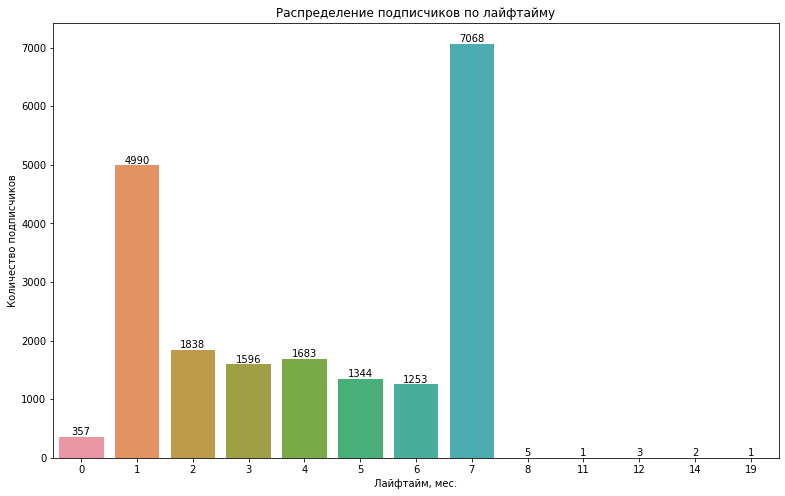

In [ ]:
# построим столбчатую диаграмму лайфтайма пользователей

plt.figure(figsize=(13,8))
ax = sns.barplot(x='lifetime_month', y='uid', data=df_lifetime_plot)
plt.title('Распределение подписчиков по лайфтайму')
plt.bar_label(ax.containers[0])
plt.xlabel('Лайфтайм, мес.')
plt.ylabel('Количество подписчиков')
plt.show()

- 35% пользователей датасета была подписана на сервис в течение 7 месяцев.
- 24% подписчиков отказались от сервиса после второго месяца пользования. 
- Только 6 подписчиков из нашего датасета были подписаны на сервис более года.

###DAU (Daily Active Users) — количество уникальных пользователей за сутки 

Для расчета MAU и DAU сначала необходимо развернуть данные по каждому периоду подписки, чтобы учесть все временные диапазоны.

In [ ]:
# создадим новый датасет и отсортируем в нем данные по uid и date в порядке возрастания

df_expanded = df.sort_values(by=['uid', 'date'])


# создадим столбец с логами по каждой подписке
df_expanded.loc[:, "sub_date"] = df_expanded.apply(
    
    lambda x: list(
        pd.date_range(
            x.date, 
            x.end_date).date
    ),
    axis = 1
    
)

# развернем данные из столбца sub_date
df_expanded = df_expanded.explode(
    column="sub_date", ignore_index=True
)

# создадим столбец с месяцем подписки
df_expanded['sub_month'] = df_expanded['sub_date'].astype('datetime64[M]')

df_expanded

,index,uid,start_ts,end_ts,payment_platform,kind,money,duration,date,month,end_date,end_month,sub_date,sub_month
0,71012,11273xBBFkanWkYY42njwy,2020-06-27 17:09:31,2020-07-27 17:09:31,YANDEX,sub,29,30,2020-06-27,2020-06-01,2020-07-27,2020-07-01,2020-06-27,2020-06-01
1,71012,11273xBBFkanWkYY42njwy,2020-06-27 17:09:31,2020-07-27 17:09:31,YANDEX,sub,29,30,2020-06-27,2020-06-01,2020-07-27,2020-07-01,2020-06-28,2020-06-01
2,71012,11273xBBFkanWkYY42njwy,2020-06-27 17:09:31,2020-07-27 17:09:31,YANDEX,sub,29,30,2020-06-27,2020-06-01,2020-07-27,2020-07-01,2020-06-29,2020-06-01
3,71012,11273xBBFkanWkYY42njwy,2020-06-27 17:09:31,2020-07-27 17:09:31,YANDEX,sub,29,30,2020-06-27,2020-06-01,2020-07-27,2020-07-01,2020-06-30,2020-06-01
4,71012,11273xBBFkanWkYY42njwy,2020-06-27 17:09:31,2020-07-27 17:09:31,YANDEX,sub,29,30,2020-06-27,2020-06-01,2020-07-27,2020-07-01,2020-07-01,2020-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496212,24468,zyCzNz3tZZqdjv16nd5hw,2019-12-13 22:09:14,2020-01-13 22:09:14,YANDEX,sub,129,31,2019-12-13,2019-12-01,2020-01-13,2020-01-01,2020-01-09,2020-01-01
2496213,24468,zyCzNz3tZZqdjv16nd5hw,2019-12-13 22:09:14,2020-01-13 22:09:14,YANDEX,sub,129,31,2019-12-13,2019-12-01,2020-01-13,2020-01-01,2020-01-10,2020-01-01
2496214,24468,zyCzNz3tZZqdjv16nd5hw,2019-12-13 22:09:14,2020-01-13 22:09:14,YANDEX,sub,129,31,2019-12-13,2019-12-01,2020-01-13,2020-01-01,2020-01-11,2020-01-01
2496215,24468,zyCzNz3tZZqdjv16nd5hw,2019-12-13 22:09:14,2020-01-13 22:09:14,YANDEX,sub,129,31,2019-12-13,2019-12-01,2020-01-13,2020-01-01,2020-01-12,2020-01-01


In [ ]:
# рассчитаем средний DAU за весь период за исключением дней, в которых число пользователей равно одному

df_dau = df_expanded.groupby('sub_date').agg({'uid':'nunique'})
print('Средний DAU датафрейма составляет {} пользователей.'.format(int(df_dau[df_dau['uid'] > 1].mean())))

Средний DAU датафрейма составляет 5429 пользователей.


###MAU (Monthly Active Users) — количество уникальных пользователей за месяц

In [ ]:
 # рассчитаем MAU по месяцам
 
 df_mau = df_expanded.groupby('sub_month').agg({'uid':'nunique'})
 df_mau

,uid
sub_month,
2018-12-01,1
2019-01-01,1
2019-02-01,1
2019-03-01,1
2019-04-01,1
2019-05-01,1
2019-06-01,1
2019-07-01,1
2019-08-01,1


In [ ]:
# рассчитаем средний MAU для месяцев, где подписчиков было более 14

print('Средний MAU датарейма составляет {} пользователей.'.format(int(df_mau[df_mau['uid'] > 14].mean())))

Средний MAU датарейма составляет 12718 пользователей.


###Когортный анализ: расчет Retention

In [ ]:
# подготовим датасет, в котором пользователи буду сгруппированы по первой дате оформления подписки

df_uid = df.groupby('uid').agg({'date':'min'}).reset_index()
df_uid = df_uid.rename(columns={'date':'first_date'})

# создадим столбик с первым днем месяца даты подписок
df_uid['first_month'] = df_uid['first_date'].astype('datetime64[M]')
df_raw = df_uid.merge(df, on='uid', how='left')

# вычислим лайфтайм в месяцах по каждой строке
df_raw['lifetime_month'] = df_raw['date'].dt.to_period('M').view(dtype='int64') - df_raw['first_date'].dt.to_period('M').view(dtype='int64')


# создадим таблицу когорт с группировкой на каждому месяцу лайфтайма

result_grouped = df_raw.pivot_table(
    index='first_month', 
    columns='lifetime_month', 
    values='uid', 
    aggfunc='nunique'
)

# вычислим размеры когорт
cohort_sizes = (
    df_raw.groupby('first_month')
    .agg({'uid': 'nunique'})
    .rename(columns={'uid': 'cohort_size'})
)

# добавим столбец размера когорт в датасет с группировкой по лайфтайму
result_grouped = (cohort_sizes.merge(
    result_grouped, 
    on='first_month', 
    how='left'
).fillna(0)).astype('int64')

# выведем на экран размеры когорт и абсолютные показатели удержания
result_grouped

,cohort_size,0,1,2,3,4,5,6,7,12,14,15,17,18
first_month,,,,,,,,,,,,,,
2018-12-01,1,1,0,0,0,0,0,0,0,1,1,1,1,1
2019-11-01,1,1,0,1,1,1,1,1,1,0,0,0,0,0
2019-12-01,11954,11954,9262,8510,7980,6953,6639,7041,19,0,0,0,0,0
2020-01-01,2158,2158,1269,1110,888,811,846,4,0,0,0,0,0,0
2020-02-01,1603,1603,1138,910,804,819,3,0,0,0,0,0,0,0
2020-03-01,1486,1486,996,815,757,4,0,0,0,0,0,0,0,0
2020-04-01,738,738,511,441,0,0,0,0,0,0,0,0,0,0
2020-05-01,475,475,330,8,0,0,0,0,0,0,0,0,0,0
2020-06-01,1722,1722,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# рассчитаем retention когорт

retention = round((result_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size']))*100,1)

retention

,0,1,2,3,4,5,6,7,12,14,15,17,18
first_month,,,,,,,,,,,,,
2018-12-01,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0
2019-11-01,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0
2019-12-01,100.0,77.5,71.2,66.8,58.2,55.5,58.9,0.2,0.0,0.0,0.0,0.0,0.0
2020-01-01,100.0,58.8,51.4,41.1,37.6,39.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,100.0,71.0,56.8,50.2,51.1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,100.0,67.0,54.8,50.9,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01,100.0,69.2,59.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-01,100.0,69.5,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-06-01,100.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Привлечение пользователей началось в декабре 2019 года. В этот месяц на сервис оформили подписку почти 12 тыс. пользователей. В следующие месяцы наблюдается резкий спад новых подписчиков. В январе 2020 года оформили подписку только 2,1 тыс. пользователей. 

- Только пользователи, которые впервые подписались в декабре 2029 года, достигают 7-месячного лайфтайма. Пользователи всех остальных когорт пользовались сервисом меньше.

- Чем больше пользователей в когорте, тем дольше их лайфтайм. Отметим когорту декабря 2019 года, у которой на 6 месяц лайфтайма было 7 тыс.подписчиков, а на 7-й осталось только 19. Такое же резкое падение подписчиков отмечается в когорте пользователей июня 2020 года: в месяц старта у нее было 1722 пользователей, а на 1-й месяц лайфтайма остался только 1.

- В какие-то месяца лайфтайма Retention когорт растет. Это означает, что после определенного перерывы их пользователи возвращаются.



###Lifetime Value

In [ ]:
# подготовим данные

ltv_grouped = df_raw.pivot_table(
    index='first_month', 
    columns='lifetime_month', 
    values='money', 
    aggfunc='sum'
)

ltv_grouped  = ltv_grouped.fillna(0).cumsum(axis=1)

cohort_sizes = (
    df_raw.groupby('first_month')
    .agg({'uid': 'nunique'})
    .rename(columns={'uid': 'cohort_size'})
)

ltv_grouped = cohort_sizes.merge(
    ltv_grouped, 
    on='first_month', 
    how='left'
)

# рассчитаем ltv

ltv = (round(ltv_grouped.div(
    result_grouped['cohort_size'], axis=0
).drop(columns=['cohort_size']))).astype('int64')

ltv

,0,1,2,3,4,5,6,7,12,14,15,17,18
first_month,,,,,,,,,,,,,
2018-12-01,0,0,0,0,0,0,0,0,129,158,187,216,245
2019-11-01,0,0,129,158,187,216,245,274,274,274,274,274,274
2019-12-01,122,222,246,266,283,299,316,316,316,316,316,316,316
2020-01-01,83,106,121,133,144,156,156,156,156,156,156,156,156
2020-02-01,35,56,73,88,103,103,103,103,103,103,103,103,103
2020-03-01,28,48,64,79,79,79,79,79,79,79,79,79,79
2020-04-01,31,51,69,69,69,69,69,69,69,69,69,69,69
2020-05-01,30,50,51,51,51,51,51,51,51,51,51,51,51
2020-06-01,29,29,29,29,29,29,29,29,29,29,29,29,29


- Больше всего прибыли принес пользователь, впервые подписавшийся на сервис в декабре 2019 года - 316 рублей.

___

Вывод:

- MAU за весь период датафрейма составляет 12718 пользователей.

- DAU - 5429 пользователей.

- Привлечение пользователей началось в декабре 2019 года. В этот месяц на сервис оформили подписку почти 12 тыс. пользователей. В следующие месяцы наблюдается резкий спад новых подписчиков. В январе 2020 года оформили подписку только 2,1 тыс. пользователей. 

- Только пользователи, которые впервые подписались в декабре 2019 года, достигают 7-месячного лайфтайма. Пользователи всех остальных когорт пользовались сервисом меньше.

- Больше всего прибыли принесли пользователи, впервые подписавшиеся на сервис в декабре 2019 года.


##Анализ платформ

Проведем сравнение платформ.

Для анализа возьмем когорты подписчиков от декабря 2019 и января 2020 и их полугодовой лайфтайм - только пользователи этих когорт набирают необходимый для анализа показатель лайфтайма в 6 месяцев.

###Накопленное число подписок

In [ ]:
# подготовим датасет, в котором пользователи буду сгруппированы по первой дате оформления подписки

df_uid = df.groupby('uid').agg({'date':'min'}).reset_index()
df_uid = df_uid.rename(columns={'date':'first_date'})


# создадим столбик с первым днем месяца даты подписок
df_uid['first_month'] = df_uid['first_date'].astype('datetime64[M]')
df_raw = df_uid.merge(df, on='uid', how='left')

# вычислим лайфтайм в месяцах по каждой строке
df_raw['lifetime_month'] = df_raw['date'].dt.to_period('M').view(dtype='int64') - df_raw['first_date'].dt.to_period('M').view(dtype='int64')

# получим нужный период и продолжительность лайфтайма
df_raw_query = df_raw[(df_raw['first_month'] == '2019-12-01') | (df_raw['first_month'] == '2020-01-01')]
df_raw_query = df_raw[df_raw['lifetime_month'] <= 6]

# создадим таблицу по платформам с группировкой по каждому месяцу лайфтайма

result_platform = df_raw_query.pivot_table(
    index='payment_platform', 
    columns='lifetime_month', 
    values='uid', 
    aggfunc='nunique'
)

result_platform  = result_platform.cumsum(axis=1)

result_platform

lifetime_month,0,1,2,3,4,5,6
payment_platform,,,,,,,
APPLE,7269,12406,17064,21430,25144,28443,31566
GOOGLE,4557,7409,9818,11761,13166,14377,15581
YANDEX,8317,13837,18567,22690,26159,29139,31858


- Больше всего подписок было оплачено с помощью платформы Yandex - 31 858.
- Почти столько же накопленных подписок у платформы Apple - 31566.
- Меньше всего подписок у Google - 15581. 


###Сравнение выручки платформ

In [ ]:
# создадим таблицу кумулятивной выручки платформ 

result_platform_rev = df_raw_query.pivot_table(
    index='payment_platform', 
    columns='lifetime_month', 
    values='money', 
    aggfunc='sum'
)

result_platform_rev  = result_platform_rev.cumsum(axis=1)


result_platform_rev

lifetime_month,0,1,2,3,4,5,6
payment_platform,,,,,,,
APPLE,730427,1250371,1405288,1533729,1641493,1737715,1828311
GOOGLE,434608,711978,793695,850593,891541,926718,961663
YANDEX,656409,1189328,1342685,1462571,1563143,1649563,1728414


- Больше всего выручки принесла платформа Apple - 1 828 311 руб.
- На втором месте - Yandex - с результатом 1 728 414 руб.
- Наименее прибыльная платформа - Google. Она принесла сервису 961 663 руб. 

###Сравнение LTV платформ

In [ ]:
# подготовим данные и выведем таблицу LTV по платформам

result_platform_ltv = df_raw_query.pivot_table(
    index='payment_platform', 
    columns='lifetime_month', 
    values='money', 
    aggfunc='sum'
).cumsum(axis=1)



cohort_sizes_query = (
    df_raw_query.groupby('payment_platform')
    .agg({'uid': 'nunique'})
    .rename(columns={'uid': 'cohort_size'})
)

# добавим столбец размера когорт в датасет с группировкой по лайфтайму
result_platform_ltv = cohort_sizes_query.merge(
    result_platform_ltv, 
    on='payment_platform', 
    how='left'
).fillna(0)

# рассчитаем ltv когорт

result_platform_ltv = (round(result_platform_ltv.div(
    result_platform_ltv['cohort_size'], axis=0
).drop(columns=['cohort_size']))).astype('int64')

result_platform_ltv

,0,1,2,3,4,5,6
payment_platform,,,,,,,
APPLE,97,165,186,203,217,230,242
GOOGLE,92,151,168,180,189,196,203
YANDEX,77,140,158,172,183,194,203


- Средний пользователь сервиса, оплативший подписку с платформы Apple, принес 242 руб.
- Пользователи, оплатившие подписку с платформ Google и Yandex, принесли одинаковую прибыль - 203 руб.

###Сравнение Retention платформ

In [ ]:
# подготовим данные и выведем таблицу LTV по платформам

result_platform_retention = df_raw_query.pivot_table(
    index='payment_platform', 
    columns='lifetime_month', 
    values='uid', 
    aggfunc='nunique'
)

cohort_sizes_query = (
    df_raw_query[df_raw_query['lifetime_month'] == 0].groupby('payment_platform')
    .agg({'uid': 'nunique'})
    .rename(columns={'uid': 'cohort_size'})
)

# добавим столбец размера когорт в датасет с группировкой по лайфтайму
result_platform_retention = cohort_sizes_query.merge(
    result_platform_retention, 
    on='payment_platform', 
    how='left'
).fillna(0)

# рассчитаем retention когорт

result_platform_retention = round(result_platform_retention.div(
    result_platform_retention['cohort_size'], axis=0
).drop(columns=['cohort_size'])*100,2)

result_platform_retention

,0,1,2,3,4,5,6
payment_platform,,,,,,,
APPLE,100.0,70.67,64.08,60.06,51.09,45.38,42.96
GOOGLE,100.0,62.59,52.86,42.64,30.83,26.57,26.42
YANDEX,100.0,66.37,56.87,49.57,41.71,35.83,32.69


- Лучше всего на 6-й месяц лайфтайма удерживаются пользователи, оплатившие подписку с помощью платформы APPLE - 42% подписчиков продолжают пользоваться сервисом. 
- Хуже всех результат у Google. Только 26% подписчиков, оплативших сервис с помощью этой платформы, на 6 месяц лайфтайма остаются клиентами сервиса.

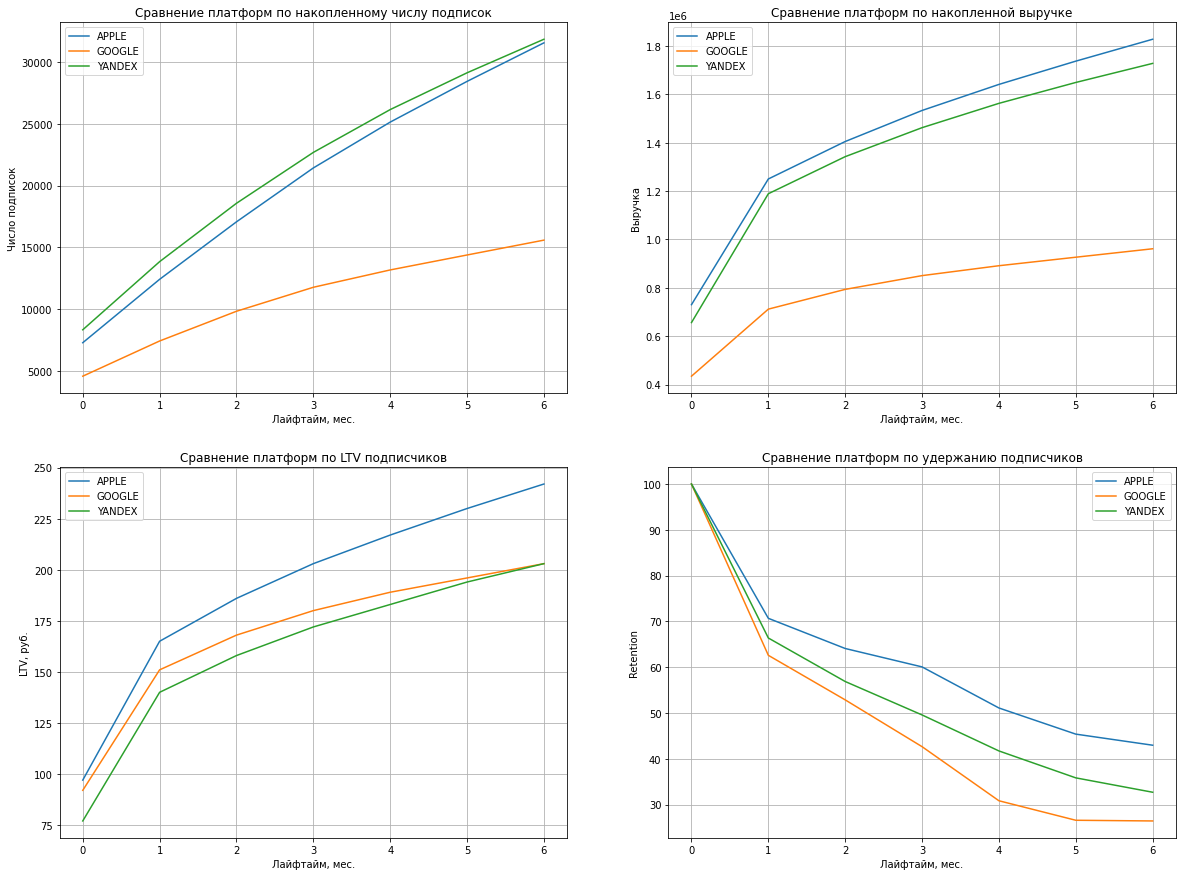

In [ ]:
# построим графики метрик платформ

plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.plot(result_platform.T)
plt.legend(list(result_platform.T.columns.values))
plt.grid()
plt.xlabel('Лайфтайм, мес.')
plt.ylabel('Число подписок')
plt.title('Сравнение платформ по накопленному числу подписок')


plt.subplot(2,2,2)
plt.plot(result_platform_rev.T)
plt.legend(list(result_platform_rev.T.columns.values))
plt.grid()
plt.xlabel('Лайфтайм, мес.')
plt.ylabel('Выручка')
plt.title('Сравнение платформ по накопленной выручке')


plt.subplot(2,2,3)
plt.plot(result_platform_ltv.T)
plt.legend(list(result_platform_ltv.T.columns.values))
plt.grid()
plt.xlabel('Лайфтайм, мес.')
plt.ylabel('LTV, руб.')
plt.title('Сравнение платформ по LTV подписчиков')

plt.subplot(2,2,4)
plt.plot(result_platform_retention.T)
plt.legend(list(result_platform_retention.T.columns.values))
plt.grid()
plt.xlabel('Лайфтайм, мес.')
plt.ylabel('Retention')
plt.title('Сравнение платформ по удержанию подписчиков')
plt.show()

Вывод:


- Худшие результаты  показывает платформа Google. По абсолютным показателям выручки, числа оплаченных подписок и удержанию пользователей эта платформа отстает от других. При этом средний подписчик, оплативший сервис с помощью Google, приносит сервису сравнимую с Yandex выручку - 203 рубля.

- Пользователь Apple приносит сервису больше всего выручки. Его показатель LTV составил 242 руб.

- Возможно, пользователи испытывают проблемы при оплате сервиса с помощью платформы Google.  Это вынуждает их искать альтернативные способы оплаты.